# Recommendations with IBM

A number of different methods for making recommendations for articles within IBM. 


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations (To be added in the future)](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>
VI. [Concluding](#conclusions)


In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

%matplotlib inline

df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

# Show df to get an idea of the data
df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [19]:
# Show df_content to get an idea of the data
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>


In [20]:
df.groupby(['article_id', 'title'])['email'].count().sort_values(ascending = False).head(15)

article_id  title                                                             
1429.0      use deep learning for image classification                            937
1330.0      insights from new york car accident reports                           927
1431.0      visualize car data with brunel                                        671
1427.0      use xgboost, scikit-learn & ibm watson machine learning apis          643
1364.0      predicting churn with the spss random tree algorithm                  627
1314.0      healthcare python streaming application demo                          614
1293.0      finding optimal locations of new store using decision optimization    572
1170.0      apache spark lab, part 1: basic concepts                              565
1162.0      analyze energy consumption in buildings                               512
1304.0      gosales transactions for logistic regression model                    483
1436.0      welcome to pixiedust                             

In [21]:
counts = pd.DataFrame(df.groupby(['email'])['article_id'].count())

In [22]:
# Fill in the median and maximum number of user_article interactions below

median_val = counts.article_id.median()
max_views_by_user = counts.article_id.max()

50% of individuals interact with 3.0 number of articles or fewer
The maximum number of user-article interactions by any 1 user is 364.


`2.` Explore and remove duplicate articles from the **df_content** dataframe.  

In [23]:
# Find and explore duplicate articles
df_content.groupby(['doc_full_name'])['article_id'].count().sort_values(ascending = False).head(10)

doc_full_name
Self-service data preparation with IBM Data Refinery                                            2
Use the Primary Index                                                                           2
How smart catalogs can turn the big data flood into an ocean of opportunity                     2
Using Apache Spark as a parallel processing framework for accessing REST based data services    2
Graph-based machine learning                                                                    2
Export Cloudant JSON as CSV, RSS, or iCal                                                       1
Extract and export dashDB data to a CSV file                                                    1
Eye Candy for Cloudant – IBM Watson Data Lab – Medium                                           1
Faster Operations with the jsonb Data Type in PostgreSQL                                        1
Faster Performance with Unlogged Tables in PostgreSQL                                           1
Name: 

In [24]:
# Remove any rows that have the same article_id - only keep the first
df_content.drop_duplicates(subset=['article_id'], keep='first', inplace=True)

`3.`
**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [25]:
unique_articles = df.article_id.nunique()# The number of unique articles that have at least one interaction
total_articles = df_content.article_id.nunique()# The number of unique articles on the IBM platform
unique_users = df[~df.email.isnull()].email.nunique() # The number of unique users
user_article_interactions = df.shape[0]# The number of user-article interactions

`4.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [26]:
top_article = df.groupby(['article_id'])['email'].count().sort_values(ascending = False).head(1)

In [27]:
most_viewed_article_id = str(top_article.keys()[0])# The most viewed article in the dataset as a string with one value following the decimal 
max_views = top_article.max()# The most viewed article in the dataset was viewed how many times?

In [28]:
# Run this cell to map the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [29]:
sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

sol_1_dict

{'`50% of individuals have _____ or fewer interactions.`': 3.0,
 '`The total number of user-article interactions in the dataset is ______.`': 45993,
 '`The maximum number of user-article interactions by any 1 user is ______.`': 364,
 '`The most viewed article in the dataset was viewed _____ times.`': 937,
 '`The article_id of the most viewed article is ______.`': '1429.0',
 '`The number of unique articles that have at least 1 rating ______.`': 714,
 '`The number of unique users in the dataset is ______`': 5148,
 '`The number of unique articles on the IBM platform`': 1051}

### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

We don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` Return the **n** top articles ordered with most interactions as the top.

In [30]:
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    elements = df.groupby(['article_id', 'title'])['user_id'].count().sort_values(ascending = False).head(n).keys().tolist()
    top_articles = [x[1] for x in elements]
    return top_articles 

def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - Z1221`(pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    elements = df.groupby(['article_id', 'title'])['user_id'].count().sort_values(ascending = False).head(n).keys().tolist()
    top_articles = [str(x[0]) for x in elements]
 
    return top_articles 

In [31]:
print(get_top_articles(10))
print(get_top_article_ids(10))

['use deep learning for image classification', 'insights from new york car accident reports', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'healthcare python streaming application demo', 'finding optimal locations of new store using decision optimization', 'apache spark lab, part 1: basic concepts', 'analyze energy consumption in buildings', 'gosales transactions for logistic regression model']
['1429.0', '1330.0', '1431.0', '1427.0', '1364.0', '1314.0', '1293.0', '1170.0', '1162.0', '1304.0']


In [33]:
# Test by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

top_20

['use deep learning for image classification',
 'insights from new york car accident reports',
 'visualize car data with brunel',
 'use xgboost, scikit-learn & ibm watson machine learning apis',
 'predicting churn with the spss random tree algorithm',
 'healthcare python streaming application demo',
 'finding optimal locations of new store using decision optimization',
 'apache spark lab, part 1: basic concepts',
 'analyze energy consumption in buildings',
 'gosales transactions for logistic regression model',
 'welcome to pixiedust',
 'customer demographics and sales',
 'total population by country',
 'deep learning with tensorflow course by big data university',
 'model bike sharing data with spss',
 'the nurse assignment problem',
 'classify tumors with machine learning',
 'analyze accident reports on amazon emr spark',
 'movie recommender system with spark machine learning',
 'putting a human face on machine learning']

### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 


In [34]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    
    user_item = (pd.crosstab(df['user_id'], df['article_id'].astype('str')) > 0).astype(int)
    
    return user_item # return the user_item matrix 

user_item = create_user_item_matrix(df)

In [35]:
user_item.shape[0], user_item.shape[1], user_item.sum(axis=1)[1]

(5149, 714, 36)

`2.` The function below should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

In [36]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    
    '''
    
     # compute similarity of each user to the provided user
     # sort by similarity
     # create list of just the ids
     # remove the own user's id

    results = pd.DataFrame()
    dot_products = []
    user_ids = []

    for i in user_item.index.unique():
        dot_products.append(user_item.loc[user_id].dot(np.transpose(user_item.loc[i])))
        user_ids.append(i)
        
    results['dot_product'] = dot_products
    results['user_ids'] = user_ids
    results.sort_values(by = 'dot_product', ascending = False, inplace = True)
    most_similar_users = results[results.user_ids != user_id].user_ids.values
    
    return most_similar_users # return a list of the users in order from most to least similar
        

In [37]:
# Do a spot check
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933   23 3782  203 4459 3870  131 4201   46 5041]
The 5 most similar users to user 3933 are: [   1   23 3782  203 4459]
The 3 most similar users to user 46 are: [4201 3782   23]


`3.` Function below return the articles you would recommend to each user. 

In [38]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    article_names = df[df['article_id'].isin(article_ids)]['title'].unique().tolist()
    
    return article_names # Return the article names associated with list of article ids


def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    
    if user_id not in user_item.index.tolist():
        return [], []
    
    else:    
        series = user_item.loc[user_id]
        article_ids = list(map(str, series[series.values > 0].index))
        article_names = get_article_names(article_ids)
    
        return article_ids, article_names # return the ids and names


def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''
    recs = []
    
    articles_seen = get_user_articles(user_id)
    if len(articles_seen) > 0:
        articles_seen = articles_seen[0]
    
    for i in find_similar_users(user_id):
    
        try:
            user_articles = get_user_articles(i)[0]
            [recs.append(r) for r in set(user_articles) - set(articles_seen)]

            if len(set(recs)) >= m:
                break
        except:
            pass
        
    recs = list(set(recs))[0:m]
    
    return recs # return your recommendations for this user_id    

In [39]:
# Check Results
get_article_names(user_user_recs(1, 10)) # Return 10 recommendations for user 1

['gosales transactions for logistic regression model',
 'leverage python, scikit, and text classification for behavioral profiling',
 'optimizing a marketing campaign: moving from predictions to actions',
 'better together: spss and data science experience',
 'learn basics about notebooks and apache spark',
 'deep forest: towards an alternative to deep neural networks',
 'data tidying in data science experience',
 'recommender systems: approaches & algorithms',
 '54174    detect potentially malfunctioning sensors in r...\nName: title, dtype: object',
 'a tensorflow regression model to predict house values']

In [41]:
# Test your functions here - No need to change this code - just run this cell
get_article_names(['1320.0', '232.0', '844.0']), get_user_articles(20)[1]

(['housing (2015): united states demographic measures',
  'use the cloudant-spark connector in python notebook',
  'self-service data preparation with ibm data refinery'],
 ['housing (2015): united states demographic measures',
  'use the cloudant-spark connector in python notebook',
  'self-service data preparation with ibm data refinery'])

`4.` Improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [42]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
    neighbors_df = pd.DataFrame()
    similarity = []
    neighbor_id = []

    for i in user_item.index.unique():
        similarity.append(user_item.loc[user_id].dot(np.transpose(user_item.loc[i])))
        neighbor_id.append(i)
        
    neighbors_df['similarity'] = similarity
    neighbors_df['neighbor_id'] = neighbor_id
    neighbors_df['num_interactions'] = user_item.loc[neighbors_df['neighbor_id']].sum(axis=1)
    
    neighbors_df = neighbors_df[neighbors_df.neighbor_id != user_id]
    
    neighbors_df.sort_values(by = ['similarity', 'num_interactions'], ascending = False, inplace = True)
    
    return neighbors_df # Return the dataframe specified in the doc_string


def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    '''
    recs = []
    sorted_articles = get_top_article_ids(df.article_id.nunique())
    
    articles_seen = get_user_articles(user_id)[0]
    
    if len(articles_seen) > 0: #if user is new and hasn't seen any articles before, send top articles in else portion
    
        for i in get_top_sorted_users(user_id).neighbor_id:
    
            try:
                user_articles = get_user_articles(i)[0]
                user_articles = sorted(user_articles, key=lambda x: sorted_articles.index(x))
                [recs.append(r) for r in set(user_articles) - set(articles_seen)]

            except:
                pass
            if len(set(recs)) >= m: #break the loop if we've already passed m articles
                break
    else:
        recs = sorted_articles
    
    recs = list(dict.fromkeys(recs))[0:m]
    
    rec_names = get_article_names(recs)
    
    return recs, rec_names

In [43]:
# Quick spot check
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
['1164.0', '609.0', '379.0', '1059.0', '111.0', '316.0', '1336.0', '491.0', '273.0', '1172.0']

The top 10 recommendations for user 20 are the following article names:
['analyze open data sets with pandas dataframes', 'apache spark lab, part 3: machine learning', 'leverage python, scikit, and text classification for behavioral profiling', 'airbnb data for analytics: amsterdam calendar', 'simple linear regression? do it the bayesian way', 'tidy up your jupyter notebooks with scripts', 'learn basics about notebooks and apache spark', 'this week in data science (may 23, 2017)', 'data structures related to machine learning algorithms', 'statistical bias types explained (with examples)']


In [44]:
user1_most_sim = get_top_sorted_users(1).iloc[0]['neighbor_id'] # Find the user that is most similar to user 1 
user131_10th_sim = get_top_sorted_users(131).iloc[9]['neighbor_id']# Find the 10th most similar user to user 131

user1_most_sim, user131_10th_sim

(3933.0, 242.0)

`6.` A better method for new users:

**Given a new user, we would be able to use either of the functions above to make recommendations for new users. The user_user_recs_part2 would be better in my opinion because instead of arbitrary order of articles recommended (since all users will have 0 similarity), the new users would be proivided with recommendations ordered by users who have had most activity. A better method would be to instead provide the new users with recommendations ordered by most popular article (with most interactions). I went back and added this route for new users in the user_user_recs_part2 function**

`7.` Provide the top 10 recommended articles you would provide for the a new user below.

In [45]:
new_user = '0.0'

# What would your recommendations be for this new user '0.0'?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to 
new_user_recs = user_user_recs_part2(new_user, m=10)[0]
new_user_recs

['1429.0',
 '1330.0',
 '1431.0',
 '1427.0',
 '1364.0',
 '1314.0',
 '1293.0',
 '1170.0',
 '1162.0',
 '1304.0']

In [46]:
assert set(new_user_recs) == set(['1314.0','1429.0','1293.0','1427.0','1162.0','1364.0','1304.0','1170.0','1431.0','1330.0']), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Content-Recs">Part IV: Content Based Recommendations (To be added in the future)</a>

Another method we might use to make recommendations is to perform a ranking of the highest ranked articles associated with some term.  Might consider content to be the **doc_body**, **doc_description**, or **doc_full_name**.  There isn't one way to create a content based recommendation, especially considering that each of these columns hold content related information.  

`1.` Content based recommender


In [47]:
def make_content_recs():
    '''
    INPUT:
    
    OUTPUT:
    
    '''

`2.` A summary explaining how your content based recommender works.  Any possible improvements that could be made to your function?  Anything novel about the content based recommender?


`3.` Make recommendations for the below scenarios based on the comments.

In [48]:
# make recommendations for a brand new user


# make a recommendations for a user who only has interacted with article id '1427.0'



### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

Use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

`1.` Setup

In [50]:
# Load the matrix here
user_item_matrix = pd.read_pickle('user_item_matrix.p')

In [51]:
# quick look at the matrix
user_item_matrix.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


`2.` Use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.

In [52]:
# Perform SVD on the User-Item Matrix Here

u, s, vt = np.linalg.svd(user_item) # use the built in to get the three matrices

`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.

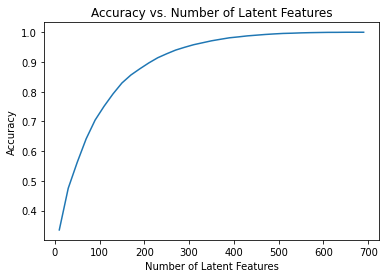

In [53]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

Understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below: 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?  
* How many articles are we not able to make predictions for because of the cold start problem?

In [54]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
    user_item_train = create_user_item_matrix(df_train)
    user_item_test = create_user_item_matrix(df_test)
    test_idx = user_item_test.index
    test_arts = user_item_test.columns
    
    return user_item_train, user_item_test, test_idx, test_arts

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

In [55]:
len(user_item_train.columns), len(user_item_test.columns) 

(714, 574)

In [57]:
# Replace the values in the dictionary below
a = 662 
b = 574 
c = 20 
d = 0 

#there is an issue with the test where it is looking for the key to be related to movies instead of articles

sol_4_dict = {
    'How many users can we make predictions for in the test set?': c, 
    'How many users in the test set are we not able to make predictions for because of the cold start problem?': a, 
    'How many movies can we make predictions for in the test set?': b,
    'How many movies in the test set are we not able to make predictions for because of the cold start problem?': d
}

sol_4_dict

{'How many users can we make predictions for in the test set?': 20,
 'How many users in the test set are we not able to make predictions for because of the cold start problem?': 662,
 'How many movies can we make predictions for in the test set?': 574,
 'How many movies in the test set are we not able to make predictions for because of the cold start problem?': 0}

`5.` Find **user_item_train** U, S, and V transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that we can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. 
  

In [58]:
# Use these cells to see how well you can use the training 
# decomposition to predict on test data

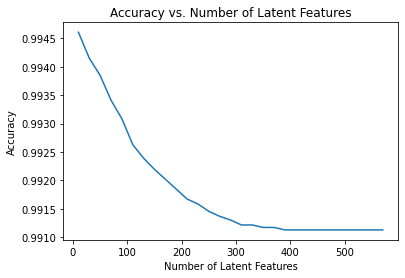

In [59]:
# fit SVD on the user_item_train matrix
u_train, s_train, vt_train = np.linalg.svd(user_item_train)# fit svd similar to above then use the cells below
    
num_latent_feats = np.arange(10,len(test_arts)+10,20)

train_error_sum = []
test_error_sum = []

row_idx = user_item_train.index.isin(test_idx)
col_idx = user_item_train.columns.isin(test_arts)

u_test = u_train[row_idx, :]
vt_test = vt_train[:, col_idx]

for k in num_latent_feats:
    
    # restructure with k latent features
    s_train_new, u_train_new, vt_train_new = np.diag(s_train[:k]), u_train[:, :k], vt_train[:k, :]
    u_test_new, vt_test_new = u_test[:, :k], vt_test[:k, :]
    
    # take dot product
    user_item_train_est = np.around(np.dot(np.dot(u_train_new, s_train_new), vt_train_new))
    user_item_test_est = np.around(np.dot(np.dot(u_test_new, s_train_new), vt_test_new))
    
    # compute error for each prediction to actual value
    
    train_diffs = np.subtract(user_item_train, user_item_train_est)
    test_diffs = np.subtract(user_item_test.loc[test_idx.intersection(user_item_train.index),:], user_item_test_est)
    
    train_error = np.sum(np.sum(np.abs(train_diffs)))
    test_error = np.sum(np.sum(np.abs(test_diffs)))
    train_error_sum.append(train_error)
    test_error_sum.append(test_error)
    
plt.plot(num_latent_feats, 1 - np.array(test_error_sum)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`6.` Given the circumstances of your results, what might we be able to do to determine if the recommendations you make with any of the above recommendation systems are an improvement to how users currently find articles? 

**The accuracy on the test data worsens as we increase the number of latent features. There are only 20 users we are able to test on though. Given these circumstances, to better determine if the recommendations I made with any of the above systems are an improvement, I would set up a poll for users to rate for me**